In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch import optim

print('torch.cuda.is_available():', torch.cuda.is_available())
print('torch.cuda.device_count():', torch.cuda.device_count())

torch.cuda.is_available(): True
torch.cuda.device_count(): 1


In [3]:
import random
import numpy as np
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt

import utils
import models
import fl_utils as fl

In [4]:
# Set a seed value
seed = 42 
os.environ['PYTHONHASHSEED']=str(seed)
torch.manual_seed(0)
random.seed(seed)
np.random.seed(seed)

In [5]:
save_interval = 10
save_dir = './output/moon'
os.makedirs(save_dir, exist_ok=True)

In [6]:
batch_size = 32
num_workers = 2

data_dir = './data/'
train_dir = os.path.join(data_dir, 'client_data')
valid_dir = os.path.join(data_dir, 'valid_sub')

# For testing the global model.
transform = transforms.Compose([transforms.Resize((96, 96)), transforms.ToTensor()])
valid_data = ImageFolder(valid_dir, transform=transform)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
num_classes = len(valid_data.classes)

In [7]:
# To create custom dataset.
label_idx_dict = dict()
for idx, key in enumerate(sorted(valid_data.classes)):
    label_idx_dict[key] = idx
label_idx_dict

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___healthy': 2,
 'Corn___Common_rust': 3,
 'Corn___Northern_Leaf_Blight': 4,
 'Corn___healthy': 5,
 'Grape___Black_rot': 6,
 'Grape___Esca_(Black_Measles)': 7,
 'Grape___healthy': 8,
 'Tomato___Early_blight': 9,
 'Tomato___Septoria_leaf_spot': 10,
 'Tomato___healthy': 11}

In [8]:
# To remap labels to class names.
idx_label_dict = dict((value, key) for key, value in label_idx_dict.items())
# idx_label_dict

In [9]:
client_list = sorted(os.listdir(train_dir))
print(client_list)

['client_0', 'client_1', 'client_2', 'client_3', 'client_4', 'client_5', 'client_6', 'client_7']


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
glob_model = models.CNNModel(num_classes)
glob_model.to(device)
glob_w = glob_model.state_dict()

In [11]:
num_rounds = 400
num_local_epochs = 3
num_workers = 2

metric_keys = {'train_loss', 'train_acc', 'valid_loss', 'valid_acc'}
_, performance_log = utils.get_performance_loggers(metric_keys)

# Initialize prev_w for each client.
prev_w_dict = dict()
for client in client_list:
    prev_w_dict[client] = copy.deepcopy(glob_w)
    
use_loss_con = False

for round_no in range(num_rounds):
    utils.print_separator(text='Round: {}'.format(round_no))
    client_updates = dict()
    
    if round_no > 100:
        use_loss_con = True
    
    # Federated training.
    for client in client_list:
        print('client:', client)
        client_data_dir = os.path.join(train_dir, client)
        client_dataset = fl.MultiClassClientData(client_data_dir, label_idx_dict, transform=transform)
        client_data_loader = torch.utils.data.DataLoader(client_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        prev_w = prev_w_dict[client]
        client_update = fl.local_update_moon(models.CNNModel(num_classes).to(device), glob_w, prev_w, client_data_loader, num_local_epochs, use_loss_con=use_loss_con)
        for key in ['local_w', 'num_samples', 'loss', 'acc']:
            client_updates.setdefault(key, list()).append(client_update[key])
        prev_w_dict[client] = copy.deepcopy(client_update['local_w'])   
        
    # Model aggregation.
    glob_w = fl.weighted_averaging(client_updates['local_w'], client_updates['num_samples'])
    glob_model.load_state_dict(glob_w)
    
    # Average training performance.
    performance_log['train_loss'].append(sum(client_updates['loss'])/len(client_updates['loss']))
    performance_log['train_acc'].append(sum(client_updates['acc'])/len(client_updates['acc']))
    
    # Validate the global model.
    valid_loss, valid_acc = fl.evaluate_model(glob_model, valid_loader)
    performance_log['valid_loss'].append(valid_loss)
    performance_log['valid_acc'].append(valid_acc)
    
    utils.print_result(performance_log)
    
    if  (round_no + 1) % save_interval == 0:
        torch.save(glob_model.state_dict(), os.path.join(save_dir, 'round_{}_loss_{:.2f}_acc_{:.2f}.pth'.format(round_no+1, performance_log['valid_loss'][-1], performance_log['valid_acc'][-1])))
        
utils.save_pickle(os.path.join(save_dir, 'performance_log.pickle'), performance_log)
    


 ==================== Round: 0 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    1.0929          acc:    0.3626
valid     -              loss :    2.4847          acc:    0.0716


 ==================== Round: 1 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    1.0762          acc:    0.3868
valid     -              loss :    2.4797          acc:    0.1007


 ==================== Round: 2 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    1.0423          acc:    0.3893
valid     -              loss :    2.4629          acc:    0.1007


 ==================== Round: 3

client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.1329          acc:    0.9504
valid     -              loss :    1.7317          acc:    0.3881


 ==================== Round: 26 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.1510          acc:    0.9546
valid     -              loss :    1.7366          acc:    0.3765


 ==================== Round: 27 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.1352          acc:    0.9642
valid     -              loss :    1.6899          acc:    0.3983


 ==================== Round: 28 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: cli

client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0805          acc:    0.9763
valid     -              loss :    1.4270          acc:    0.5243


 ==================== Round: 52 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0268          acc:    0.9908
valid     -              loss :    1.7237          acc:    0.4142


 ==================== Round: 53 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0169          acc:    0.9940
valid     -              loss :    1.3023          acc:    0.5512


 ==================== Round: 54 ====================

client: client_0
client: client_1
client: cli

client: client_7
train     -              loss :    0.0567          acc:    0.9862
valid     -              loss :    1.6619          acc:    0.4993


 ==================== Round: 77 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0131          acc:    0.9963
valid     -              loss :    1.2674          acc:    0.6308


 ==================== Round: 78 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0635          acc:    0.9844
valid     -              loss :    1.6241          acc:    0.5418


 ==================== Round: 79 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -

client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0177          acc:    0.9952
valid     -              loss :    1.2895          acc:    0.6116


 ==================== Round: 103 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.1450          acc:    0.9926
valid     -              loss :    1.2514          acc:    0.6123


 ==================== Round: 104 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0405          acc:    0.9911
valid     -              loss :    1.2778          acc:    0.6268


 ==================== Round: 105 ====================

client: client_0
client: client_1
client: 

client: client_5
client: client_6
client: client_7
train     -              loss :    0.0237          acc:    0.9942
valid     -              loss :    1.6711          acc:    0.6268


 ==================== Round: 128 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.1170          acc:    0.9799
valid     -              loss :    1.0634          acc:    0.6726


 ==================== Round: 129 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0197          acc:    0.9949
valid     -              loss :    1.3425          acc:    0.6515


 ==================== Round: 130 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: 

client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0251          acc:    0.9939
valid     -              loss :    1.3801          acc:    0.6294


 ==================== Round: 154 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0932          acc:    0.9862
valid     -              loss :    1.1562          acc:    0.6890


 ==================== Round: 155 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0127          acc:    0.9969
valid     -              loss :    1.3574          acc:    0.6468


 ==================== Round: 156 ====================

client: client_0
client: client_1
client: 

client: client_5
client: client_6
client: client_7
train     -              loss :    0.0186          acc:    0.9957
valid     -              loss :    1.5503          acc:    0.6741


 ==================== Round: 179 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0019          acc:    0.9995
valid     -              loss :    1.4196          acc:    0.6795


 ==================== Round: 180 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0323          acc:    0.9955
valid     -              loss :    1.8788          acc:    0.6606


 ==================== Round: 181 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: 

client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0051          acc:    0.9992
valid     -              loss :    1.9948          acc:    0.6588


 ==================== Round: 205 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0110          acc:    0.9977
valid     -              loss :    1.7199          acc:    0.6857


 ==================== Round: 206 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0021          acc:    0.9989
valid     -              loss :    1.1141          acc:    0.7471


 ==================== Round: 207 ====================

client: client_0
client: client_1
client: 

client: client_5
client: client_6
client: client_7
train     -              loss :    0.0256          acc:    0.9971
valid     -              loss :    1.2452          acc:    0.7616


 ==================== Round: 230 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0468          acc:    0.9953
valid     -              loss :    1.4619          acc:    0.7115


 ==================== Round: 231 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0086          acc:    0.9973
valid     -              loss :    1.3015          acc:    0.6835


 ==================== Round: 232 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: 

client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0147          acc:    0.9968
valid     -              loss :    1.4646          acc:    0.7286


 ==================== Round: 256 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0360          acc:    0.9963
valid     -              loss :    2.0646          acc:    0.7217


 ==================== Round: 257 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0506          acc:    0.9921
valid     -              loss :    2.0693          acc:    0.6999


 ==================== Round: 258 ====================

client: client_0
client: client_1
client: 

client: client_5
client: client_6
client: client_7
train     -              loss :    0.0448          acc:    0.9934
valid     -              loss :    1.8792          acc:    0.7664


 ==================== Round: 281 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0448          acc:    0.9943
valid     -              loss :    1.9032          acc:    0.7344


 ==================== Round: 282 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.1552          acc:    0.9879
valid     -              loss :    2.2242          acc:    0.7435


 ==================== Round: 283 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: 

client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.1322          acc:    0.9853
valid     -              loss :    1.7019          acc:    0.7834


 ==================== Round: 307 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0919          acc:    0.9953
valid     -              loss :    1.9341          acc:    0.7802


 ==================== Round: 308 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0215          acc:    0.9961
valid     -              loss :    2.9003          acc:    0.7115


 ==================== Round: 309 ====================

client: client_0
client: client_1
client: 

client: client_5
client: client_6
client: client_7
train     -              loss :    0.0472          acc:    0.9945
valid     -              loss :    3.1090          acc:    0.6770


 ==================== Round: 332 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.2302          acc:    0.9812
valid     -              loss :    3.3175          acc:    0.6890


 ==================== Round: 333 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0862          acc:    0.9926
valid     -              loss :    3.1669          acc:    0.7158


 ==================== Round: 334 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: 

client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.1151          acc:    0.9850
valid     -              loss :    1.7538          acc:    0.7162


 ==================== Round: 358 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.1372          acc:    0.9869
valid     -              loss :    2.1911          acc:    0.6784


 ==================== Round: 359 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.2111          acc:    0.9885
valid     -              loss :    1.6306          acc:    0.7435


 ==================== Round: 360 ====================

client: client_0
client: client_1
client: 

client: client_5
client: client_6
client: client_7
train     -              loss :    0.1416          acc:    0.9898
valid     -              loss :    1.9392          acc:    0.7068


 ==================== Round: 383 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.1706          acc:    0.9830
valid     -              loss :    2.5714          acc:    0.6254


 ==================== Round: 384 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.1301          acc:    0.9968
valid     -              loss :    2.0698          acc:    0.6562


 ==================== Round: 385 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: 

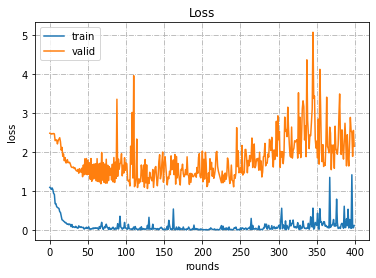

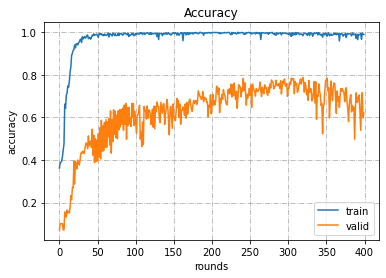

In [12]:
# Plot training history.
loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['save_dir'] = os.path.join(save_dir, 'loss.png')
loss_plot_config['show_img'] = True
utils.save_history_plot(performance_log, loss_plot_config)

acc_plot_config = utils.ACC_PLOT_CONFIG.copy()
acc_plot_config['save_dir'] = os.path.join(save_dir, 'accuracy.png')
acc_plot_config['show_img'] = True
utils.save_history_plot(performance_log, acc_plot_config)

In [11]:
# Reload model.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
glob_model = models.CNNModel(num_classes=num_classes)
glob_model.to(device)
glob_model.load_state_dict(torch.load(os.path.join(save_dir, 'round_300_loss_2.93_acc_0.70.pth')))

performance_log = utils.load_pickle(os.path.join(save_dir, 'performance_log.pickle'))

metric_keys = {'train_loss', 'train_acc', 'valid_loss', 'valid_acc'}
performance_dict, _ = utils.get_performance_loggers(metric_keys)

criterion = nn.CrossEntropyLoss()
# Validation.
glob_model.eval()
with torch.no_grad():
    for step, data in enumerate(tqdm(valid_loader)):
        x_batch, y_batch = data[0].to(device), data[1].to(device)
        _, y_pred = glob_model(x_batch)
        loss = criterion(y_pred, y_batch)
        performance_dict['valid_loss'].update_state(loss.item())
        performance_dict['valid_acc'].update_state(utils.compute_accuracy(y_batch, y_pred))
    
    print('valid_loss:', performance_dict['valid_loss'].result())
    print('valid_acc:', performance_dict['valid_acc'].result())

100%|███████████████████████████████████████████████████████████████████████████████████| 86/86 [00:03<00:00, 27.61it/s]

valid_loss: 2.932331373744673
valid_acc: 0.6994912790697675


In [12]:
t_list = [100, 200, 300]
for t in t_list:
    print('{:.2f}'.format(performance_log['valid_acc'][t-1]))

0.63
0.62
0.70


In [13]:
performance_log['valid_acc'][290:300]

[0.7721656976744186,
 0.7103924418604651,
 0.7452761627906976,
 0.7699854651162791,
 0.7590843023255814,
 0.7808866279069767,
 0.752906976744186,
 0.7456395348837209,
 0.7594476744186046,
 0.6994912790697675]

In [14]:
utils.get_mean_std(performance_log['valid_acc'][290:300])

mean:0.75
std:0.02


In [18]:
dataiter = iter(valid_loader)

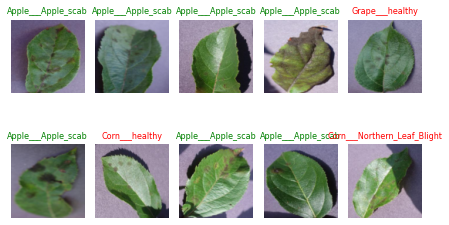

In [24]:
with torch.no_grad():
    data = dataiter.next()
    x_batch, y_batch = data[0].to(device), data[1].to(device)
    _, y_pred = glob_model(x_batch)
    _, predicted = torch.max(y_pred, 1)
    
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.imshow(transforms.ToPILImage()(x_batch[i]))
    txt_color = 'green' if (predicted[i] == y_batch[i]) else 'red'
    plt.title(valid_data.classes[predicted[i]], color=txt_color, fontsize=8)
plt.tight_layout()
plt.show()